In [1]:
#from midir import w1w2_condition
from tqdm import tqdm
import matplotlib
import os
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

import astropy
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SkyCoord
import astropy.units as u
import kcorrect.response
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = os.path.join(os.path.curdir, 'WISE variations/Final Plots 2.2.0/')
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

In [2]:
manga_file = fits.open(IMPORT_FILEPATH + '/Data/' + "mnsa-0.3.2.fits")
mnsa_hdu = manga_file[6]
mnsa = mnsa_hdu.data

manga_wise_file = fits.open(IMPORT_FILEPATH + '/Data/' + "manga-wise-variable-0.3.0.fits")
manga_wise_hdu = manga_wise_file[1]
mwv = manga_wise_hdu.data

pipe3d_file = fits.open(IMPORT_FILEPATH + '/Data/' + 'SDSS17Pipe3D_v3_1_1.fits')
pipe3d_hdu = pipe3d_file[1]
pipe3d = pipe3d_hdu.data

In [3]:
summary = manga_file[1].data
sps2 = manga_file[2].data

has_pipe3d = summary['ipipe3d '] != -1

sps2_matched = sps2[has_pipe3d]
summary_matched = summary[has_pipe3d]
mwv_matched = mwv[has_pipe3d]
mnsa_matched = mnsa[has_pipe3d]
pipe3d_matched = pipe3d[summary_matched['ipipe3d ']]

In [4]:
plateifu = mwv_matched['plateifu']

ssfr = pipe3d_matched['log_SFR_ssp']-pipe3d_matched['log_mass']
W1 = mnsa_matched['maggies'][:, 5]
W2 = mnsa_matched['maggies'][:, 6]


In [5]:
plateifuv = mwv[mwv['var_flag']==1]['plateifu']

W1v = np.array([])
W2v = np.array([])
ssfrv = np.array([])
varW2v = np.array([])

for pifu in tqdm(plateifuv):

    if pifu not in mnsa['plateifu']:
        print('this plate-IFU is not in mnsa:', pifu)
        continue
    elif pifu not in pipe3d['plateifu']:
        print('this plate-IFU is not in pipe3d:', pifu)
        continue 

    W1v = np.append(W1v, mnsa[mnsa['plateifu']==pifu]['maggies'][:, 5])
    W2v = np.append(W2v, mnsa[mnsa['plateifu']==pifu]['maggies'][:, 6])
    ssfrv = np.append(ssfrv, pipe3d[pipe3d['plateifu']==pifu]['log_SFR_ssp']-pipe3d[pipe3d['plateifu']==pifu]['log_mass'])
    varW2v = np.append(varW2v, mwv[mwv['plateifu']==pifu]['observed_W2_var'])

plateifuv = plateifuv[~(plateifuv=='8133-12702')]

 42%|████▏     | 71/170 [00:07<00:08, 11.13it/s]

this plate-IFU is not in mnsa: 8133-12702


100%|██████████| 170/170 [00:18<00:00,  9.01it/s]


C:\Users\paiaa\AppData\Local\Temp\ipykernel_18680\291566369.py:3: RuntimeWarning: invalid value encountered in divide
  plt.scatter(ssfr, -2.5*np.log10(W1/W2), s=6, alpha=0.4, c='k')
C:\Users\paiaa\AppData\Local\Temp\ipykernel_18680\291566369.py:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(ssfr, -2.5*np.log10(W1/W2), s=6, alpha=0.4, c='k')
C:\Users\paiaa\AppData\Local\Temp\ipykernel_18680\291566369.py:4: RuntimeWarning: invalid value encountered in log10
  plt.scatter(ssfrv, -2.5*np.log10(W1v/W2v), s=6, alpha=0.9, c='r')


(-1.0, 0.8)

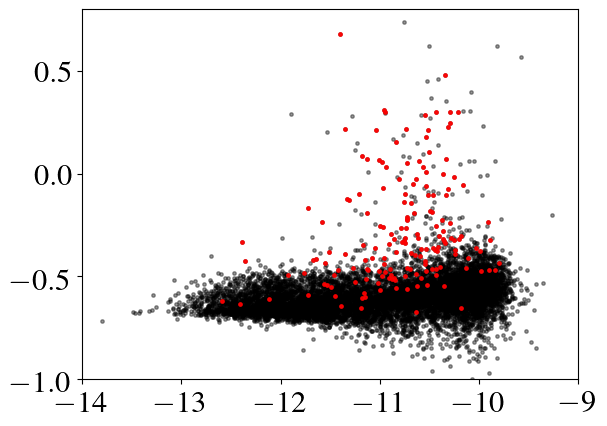

In [6]:
#W1 & W2 are already in flux (maggies)

plt.scatter(ssfr, -2.5*np.log10(W1/W2), s=6, alpha=0.4, c='k')
plt.scatter(ssfrv, -2.5*np.log10(W1v/W2v), s=6, alpha=0.9, c='r')
plt.xlim(-14,-9)
plt.ylim(-1, 0.8)

In [7]:
#binning sSFR to find median W1/W2 for the bin
bin_num = 100
bins = np.linspace(-13, -9.5, bin_num)

indices = np.digitize(ssfr, bins)

W2byW1 = W2/W1

W2byW1_medians = np.array([])
for i in range(bin_num):
    W2byW1_medians = np.append(W2byW1_medians, np.nanmedian(W2byW1[indices==i]))
    #print(indices[indices==i])

C:\Users\paiaa\AppData\Local\Temp\ipykernel_18680\15137727.py:7: RuntimeWarning: invalid value encountered in divide
  W2byW1 = W2/W1


In [8]:
indicesv = np.digitize(ssfrv, bins)

W2vbyW1v = W2v/W1v

W2v_sf = np.array([])

for i in range(plateifuv.shape[0]):

    W2v_sf = np.append(W2v_sf, W1v[i]*W2byW1_medians[indicesv[i]-1])

W2v_agn = W2v - W2v_sf

In [9]:
agn_percentage = W2v_agn/W2v
agntosf_percentage = W2v_agn/W2v_sf 

In [10]:
np.sort(agn_percentage)[::-1]

array([ 1.24985616,  0.69920271,  0.62090709,  0.5780516 ,  0.57243352,
        0.55509324,  0.55216582,  0.55077852,  0.54731572,  0.54206417,
        0.54028143,  0.53267479,  0.52992708,  0.52002608,  0.51397977,
        0.50088926,  0.49975156,  0.47911026,  0.47073674,  0.46922567,
        0.4664236 ,  0.46347101,  0.45181895,  0.45124572,  0.44828839,
        0.44806871,  0.43790185,  0.41713864,  0.41543592,  0.41004203,
        0.40389064,  0.40377103,  0.40007764,  0.39866661,  0.38331629,
        0.37847564,  0.37786377,  0.37359249,  0.37058639,  0.36995785,
        0.36776638,  0.35784694,  0.35697026,  0.35084889,  0.34865537,
        0.34656206,  0.34561029,  0.32990853,  0.32165229,  0.30422141,
        0.30283038,  0.30228463,  0.3000969 ,  0.29577127,  0.29234732,
        0.28649057,  0.2861698 ,  0.26950838,  0.2682904 ,  0.26646533,
        0.26419043,  0.25399817,  0.25012023,  0.24965533,  0.24832213,
        0.23563879,  0.23425321,  0.23211683,  0.22796843,  0.22

In [11]:
plateifuv[np.argsort(agn_percentage)][::-1]

chararray(['11863-3703', '8717-1902', '9497-12705', '8546-6103',
           '8947-3701', '11865-1901', '11838-12703', '8553-1901',
           '8091-12702', '11747-12703', '9091-3704', '12511-12705',
           '9087-6101', '9046-1902', '12071-1901', '9193-12704',
           '8723-6104', '10222-12701', '12071-12702', '12073-3704',
           '11981-3703', '9090-3701', '11940-12704', '9892-12702',
           '10493-1902', '7815-6104', '9000-1901', '9890-1901',
           '9887-1901', '8940-12702', '10498-6101', '9503-12701',
           '8446-1901', '7981-9102', '12089-6104', '9186-9101',
           '11944-12704', '8241-9102', '11943-6104', '9487-9102',
           '12511-3701', '10223-3701', '9196-12703', '12088-3701',
           '8326-6102', '8310-3701', '8713-9102', '11757-3702',
           '9514-1901', '9183-3703', '11011-1902', '12512-12702',
           '11014-9101', '9032-12701', '8091-6101', '8466-3704',
           '11974-3702', '8615-3701', '9094-6101', '8598-9102',
           '859

(0.0, 1.0)

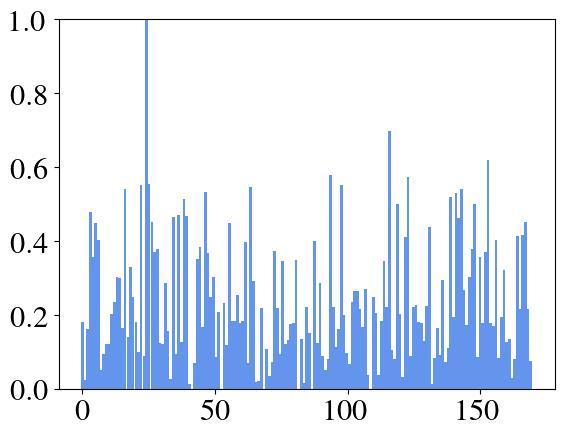

In [12]:
plt.bar(np.linspace(0, 169, 169), agn_percentage, width=1, color='cornflowerblue', align='center')
plt.ylim(0, 1)

In [13]:
agn_percentage[W2v_sf>W2v]=0

Text(0.5, 0, '$W2_{[\\rm AGN]}/W2_{[\\rm TOT]}$')

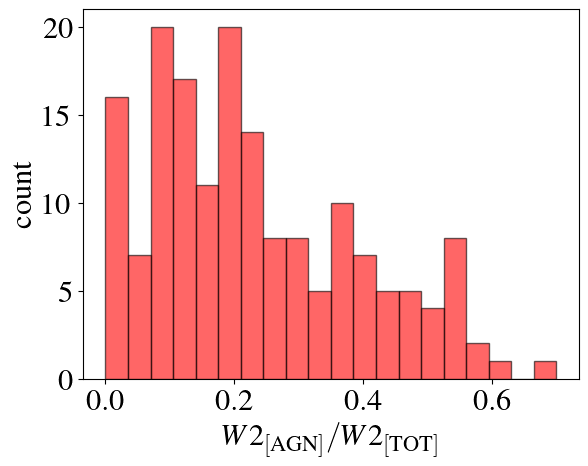

In [14]:

plt.hist(agn_percentage[((agn_percentage>=0) & (agn_percentage<=1))], bins=20, color='red', edgecolor='k', alpha=0.6)
#plt.hist(agntosf_percentage[((agntosf_percentage>=0) & (agntosf_percentage<=1))], bins=20, color='blue', edgecolor='k', alpha=0.6)

plt.ylabel('count')
plt.xlabel(r'$W2_{[\rm AGN]}/W2_{[\rm TOT]}$')

In [15]:
def logw2_to_logbolo(logw2=None):
    """Conversion from W2 luminosity to bolometric

    Parameters
    ----------

    logw2 : np.float32
        nu Lnu in W2 in erg/s

    Returns
    -------

    logbolo : np.float32
        log10 bolometric in erg/s

    Notes
    -----
    
    Uses Stern (2015), then multiplies by 20 per Comerford
"""
    loglx = 40.981 + 1.024 * (logw2 - 41.) - 0.047 * (logw2 - 41.)**2
    logbolo = loglx + np.log10(20.)
    return(logbolo)

In [16]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

fnu = 3631 * W2v_agn * u.Jy

z = np.array([])
for pifu in plateifuv:
    z = np.append(z, mnsa[mnsa['plateifu'] == pifu]['redshift'])
lnu = fnu * 4 * np.pi * (cosmo.luminosity_distance(z))**2

nu = (4.6*u.micron).to(u.Hz, equivalencies=u.spectral())

lbolo = logw2_to_logbolo(np.log10((nu*lnu).to(u.erg/u.s).value))

LbolobyLsol = (10**lbolo/4e33)

C:\Users\paiaa\AppData\Local\Temp\ipykernel_18680\3519692379.py:14: RuntimeWarning: invalid value encountered in log10
  lbolo = logw2_to_logbolo(np.log10((nu*lnu).to(u.erg/u.s).value))


In [17]:
mask = ((np.log10(LbolobyLsol)>=11) & (np.log10(LbolobyLsol)<15))
print(LbolobyLsol[mask].shape[0])
plateifuv[mask], LbolobyLsol[mask]

6


(chararray(['11747-12703', '8091-12702', '8717-1902', '9046-1902',
            '9193-12704', '9497-12705'], dtype='<U12'),
 array([1.04261493e+11, 1.28717520e+11, 4.62405960e+11, 2.26367897e+11,
        1.43378049e+11, 3.47214715e+11]))

In [22]:
LbolobyLsol

array([8.50449298e+09, 8.59953818e+08, 1.75613678e+10, 1.33474629e+10,
       5.72625841e+10, 4.68022850e+09, 5.55281632e+10, 5.65183060e+08,
       1.05284508e+10, 3.80674029e+09, 1.36689608e+10, 1.16749172e+10,
       1.35468475e+10, 1.49155042e+10, 4.27006481e+09, 1.07741748e+10,
       1.04261493e+11, 1.47997106e+10, 1.97817000e+10, 2.21990207e+09,
       8.24103855e+09, 1.68516610e+10, 2.81880450e+10, 4.28218235e+09,
                  nan, 2.83358269e+10, 3.71989532e+10, 1.39051259e+10,
       7.87437811e+10, 1.26963276e+09, 6.16789218e+09, 4.97051433e+10,
       1.22790628e+09, 6.64273640e+08, 5.88603529e+09, 7.38955789e+09,
       5.91459302e+10, 8.89587887e+09, 4.95466621e+10, 2.22080316e+10,
       1.19549549e+09,            nan, 1.56290745e+09, 4.33258680e+10,
       6.10987686e+10, 7.26541972e+06, 6.34342795e+10, 2.12274961e+10,
       3.84508681e+10, 1.97494101e+10, 1.16967259e+09, 9.27622180e+09,
                  nan, 9.87681920e+08, 5.27361886e+09, 4.86745587e+10,
      

In [18]:
ra = np.array([])
dec = np.array([])
for pifu in plateifuv:
    ra = np.append(ra, pipe3d[pipe3d['plateifu']==pifu]['objra'])
    dec = np.append(dec, pipe3d[pipe3d['plateifu']==pifu]['objdec'])

In [19]:
t = Table()
t['plateifu'] = plateifuv
t['ra'] = ra
t['dec'] = dec

#t.write('midir_vars.tbl', format='ascii.ipac', overwrite=True)
##t[100:].write('midir_variables_crts2.tbl', format='ascii.ipac', overwrite=True)

In [20]:
z

array([0.0449364 , 0.0595888 , 0.0460914 , 0.0167549 , 0.0429575 ,
       0.0385406 , 0.0479999 , 0.0142289 , 0.0897408 , 0.0233518 ,
       0.06582478, 0.06007185, 0.04846503, 0.03664102, 0.02297783,
       0.07372046, 0.06484028, 0.05135348, 0.06679182, 0.02489301,
       0.03103814, 0.07852156, 0.02150348, 0.03457265, 0.04216924,
       0.02150348, 0.03185534, 0.03045793, 0.06949385, 0.02366782,
       0.07382597, 0.06783314, 0.03401095, 0.03515374, 0.04710765,
       0.0451287 , 0.02545431, 0.03239933, 0.0421037 , 0.0465717 ,
       0.04771922, 0.05390614, 0.02706228, 0.04090169, 0.04571836,
       0.00106367, 0.04147589, 0.05246851, 0.10684215, 0.05149904,
       0.02935044, 0.0362903 , 0.05254599, 0.03726039, 0.07180065,
       0.0806967 , 0.0386619 , 0.0340641 , 0.0424723 , 0.0265918 ,
       0.0376255 , 0.0932278 , 0.0282021 , 0.133168  , 0.0390731 ,
       0.0314111 , 0.0341177 , 0.129403  , 0.0265521 , 0.0157315 ,
       0.0504819 , 0.0568681 , 0.0665263 , 0.0375422 , 0.03825

In [21]:
pipe3d[pipe3d['plateifu']=='10223-3701']['objra'], pipe3d[pipe3d['plateifu']=='10223-3701']['objdec']

(array([31.56660317], dtype='>f8'), array([-0.2914371], dtype='>f8'))